In [3]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import timm
from PIL import Image
import albumentations as A

import cv2
import os
from torch.utils.data import DataLoader

from pytorch_models_imp.detectors.centernet.datasets import VOCDataset
from pytorch_models_imp.detectors.centernet.utils import draw_bboxes, get_linear_schedule_with_warmup, get_local_maximum, get_topk_from_heatmap
from pytorch_models_imp.detectors.centernet.utils import transpose_and_gather_feat
from pytorch_models_imp.detectors.centernet.centernet import CenterNet
from pytorch_models_imp.detectors.centernet.loss import Loss

import torchvision.models as models
import torch.nn.functional as F
torch.set_printoptions(sci_mode=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Dataset

In [4]:
ROOT = "data/VOCdevkit/VOC2012"
MAX_SIZE = 512
transform = A.Compose([
    A.LongestMaxSize(max_size=MAX_SIZE),
    A.PadIfNeeded(min_height=MAX_SIZE, min_width=MAX_SIZE, border_mode=cv2.BORDER_CONSTANT)
], bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.5, label_fields=['class_labels']))



voc = VOCDataset(ROOT, transform)
voc.cut_dataset_by(0, 1000)
dataloader = DataLoader(voc, batch_size=10, collate_fn=voc.collate_fn)

class_names = voc.class_names

In [5]:
image, targets = voc[0]

### Model

In [34]:
images, targets = next(iter(dataloader))

In [35]:
model = CenterNet(num_classes=20, encoder_name='resnet18')
output = model(images)
pred_hms, pred_whs, pred_offsets = output

### Loss

In [36]:
loss = Loss()
cls_loss = loss.focal_loss(pred_hms, gt_hm)

NameError: name 'gt_hm' is not defined

### Load model

In [41]:
loaded_model = torch.load("prod_models/centernet_loss_0.06757752364501357.mdl", map_location='cpu')
loaded_model.eval()

images, targets = next(iter(dataloader))

In [42]:
result_list = loaded_model.detect(images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

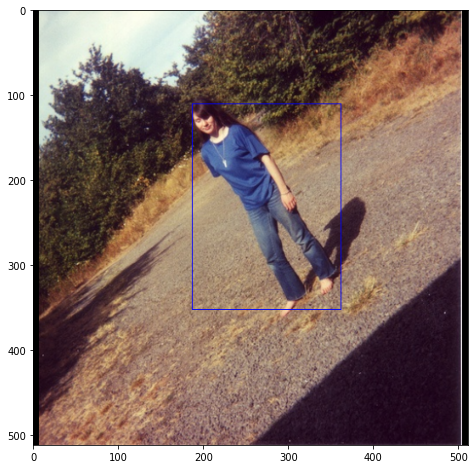

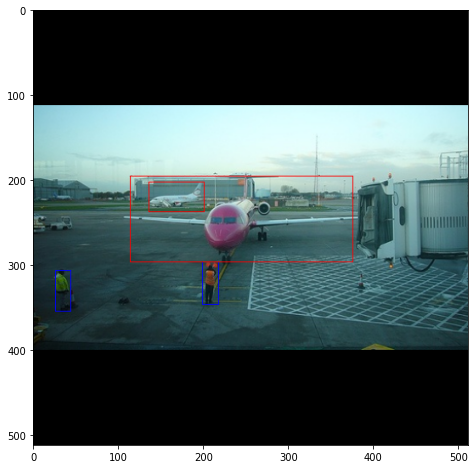

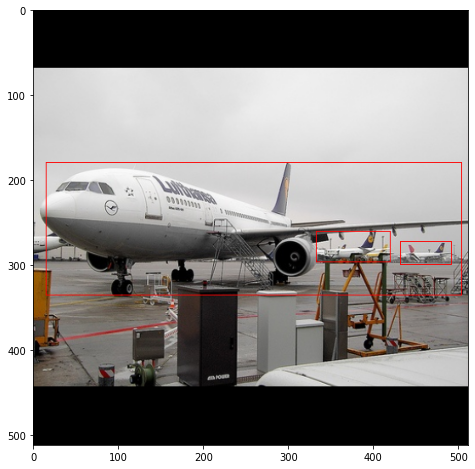

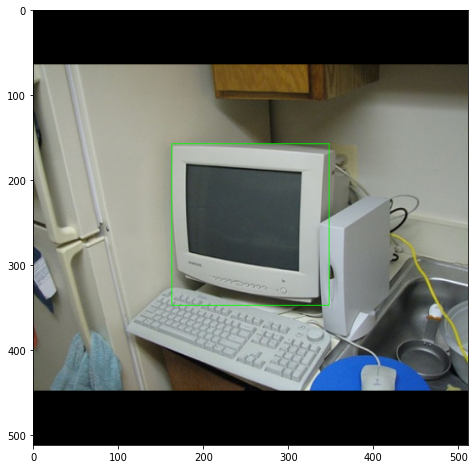

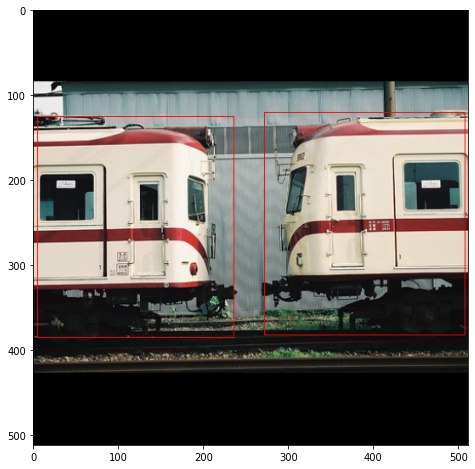

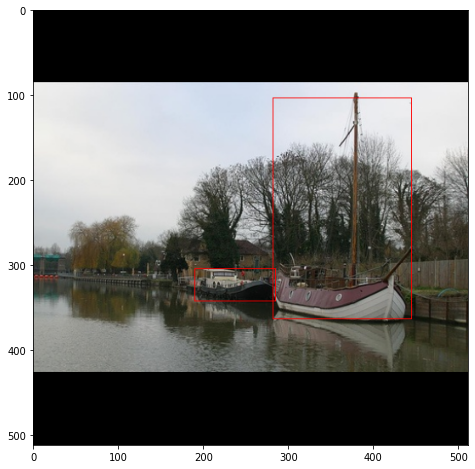

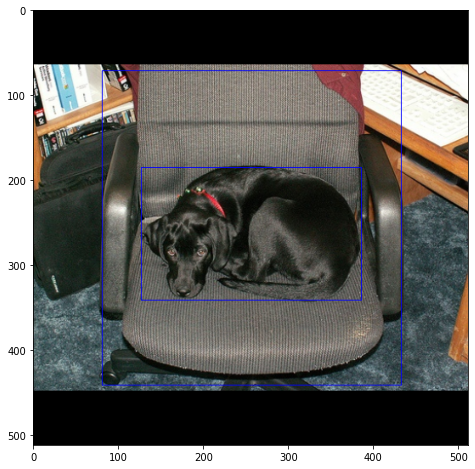

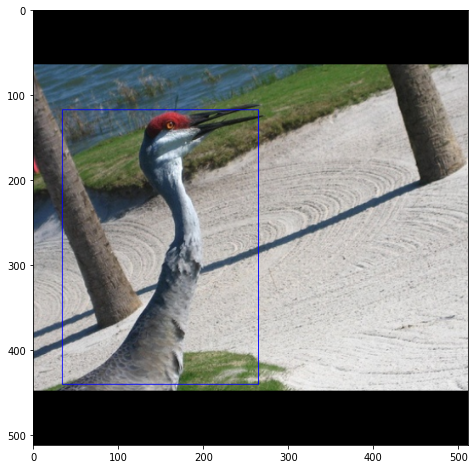

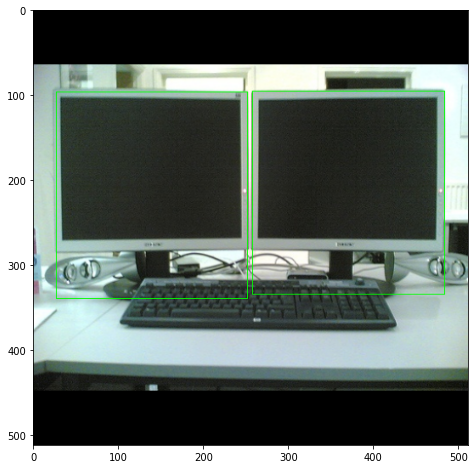

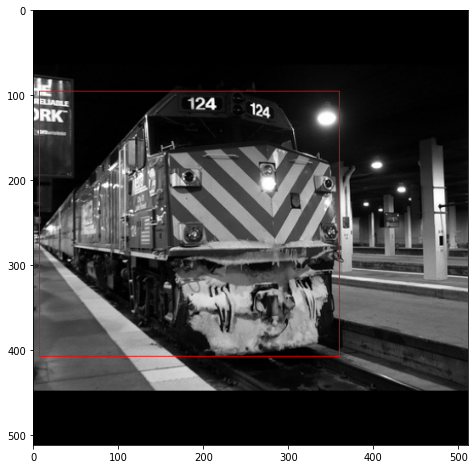

In [43]:
thr = 0.3
for i in range(images.size(0)):
    image = images[i].permute(1, 2, 0).numpy()
    
    bboxes, labels = result_list[i]
    bboxes = bboxes[0]
    labels = labels[0]
    
    
    mask = bboxes[:, -1] >= thr
    filtred_bboxes = bboxes[mask]
    filtred_labels = labels[mask]
    
    display = draw_bboxes(image, filtred_bboxes[:, :4], labels)
    plt.figure(figsize=(8, 8))
    plt.imshow(display)

### Postprocessing

In [10]:
images, targets = next(iter(dataloader))
with torch.no_grad():
    pred_hms, pred_whs, pred_offsets = loaded_model(images)

k = 100
center_heatmap_pred = get_local_maximum(pred_hms)

In [11]:
*batch_dets, topk_ys, topk_xs = get_topk_from_heatmap(
            center_heatmap_pred, k=k)
batch_scores, batch_index, batch_topk_labels = batch_dets

In [12]:
wh = transpose_and_gather_feat(pred_whs, batch_index)
offset = transpose_and_gather_feat(pred_offsets, batch_index)

In [13]:
topk_xs = topk_xs + offset[..., 0]
topk_ys = topk_ys + offset[..., 1]

tl_x = (topk_xs - wh[..., 0] / 2) * 4
tl_y = (topk_ys - wh[..., 1] / 2) * 4
br_x = (topk_xs + wh[..., 0] / 2) * 4
br_y = (topk_ys + wh[..., 1] / 2) * 4

In [14]:
batch_bboxes = torch.stack([tl_x, tl_y, br_x, br_y], dim=2)
batch_bboxes = torch.cat((batch_bboxes, batch_scores[..., None]),
                                 dim=-1)

In [22]:
tl_y

tensor([[103.4768, 140.0278, 137.8478, 120.3513, 264.9037, 167.0044,  -3.7625,
         166.9353, 148.4245, 235.0803, 138.3538, 481.2200, 123.4150, 448.7730,
         426.7869, 453.1416, 390.7791, 113.9339, 373.4301, 458.0254, 444.2295,
         500.3378, 500.3378, 122.4458,  -8.4209, 431.8304, 463.4569, 320.7430,
         500.3378,  42.1095, 501.5980, 500.3378, 136.6518,  43.5285, 461.0391,
         373.4301, 198.9313,  -7.4027, 500.3378, 473.5433, 461.4939, 501.5980,
         138.3538, 426.7869, 427.0666, 459.2514, 373.4301, 154.7655, 500.0284,
         273.1612, 138.3538,  43.5285, 500.3378,  43.5285, 157.8577, 461.0391,
         136.6518, 274.2128, 325.5056, 458.0254, 500.3378, 136.6518, 458.0254,
         379.6886, 500.3378, 458.0254, 164.7493,  84.6333, 286.8857,  -3.7625,
         251.0558,  43.5285, 373.4301, 122.7828, 458.0254, 457.0586, 251.1336,
         407.1369, 500.3378,  -7.4027, 458.0254, 461.0391,  -6.2048, 286.8857,
         475.6555, 458.0254, 138.3538, 136.6518, 448